<a href="https://colab.research.google.com/github/anandlo/Fish-Segmentation-Project/blob/main/Fish_Segmentation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras opencv-python-headless matplotlib
!pip install mrcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54907 sha256=fbc32219553dcf9ece218fb7298c0a83e06a227a6c76e2f21dbea817834b3979
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


In [ ]:
import numpy as np
import os
import cv2
import json
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, concatenate, BatchNormalization, ConvLSTM2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt


In [ ]:
def load_images_and_masks(image_dir, mask_dir, img_size=(224, 224)):
    images = []
    masks = []
    image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*.json')))

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append(img)

        # Load mask from bitmap data
        with open(mask_path, 'r') as f:
            mask_data = json.load(f)

        # Initialize an empty mask
        mask = np.zeros(img_size, dtype=np.uint8)

        # Process each object in the JSON
        for obj in mask_data['objects']:
            if obj['classTitle'] == 'fish' and 'bitmap' in obj:
                try:
                    # Decode the bitmap
                    bitmap_data = obj['bitmap']['data']
                    decoded_data = base64.b64decode(bitmap_data)
                    bitmap_img = Image.open(io.BytesIO(decoded_data))

                    # Resize bitmap to match the mask size
                    bitmap_img = bitmap_img.resize(img_size, Image.ANTIALIAS)
                    bitmap_array = np.array(bitmap_img)

                    # Update the mask where fish is detected
                    mask[bitmap_array > 0] = 1  # Assume non-zero pixels are fish

                except Exception as e:
                    print(f"Error processing bitmap for {mask_path}: {e}")

        masks.append(mask)

    # Convert lists to numpy arrays and normalize images
    images = np.array(images) / 255.0
    masks = np.expand_dims(np.array(masks), axis=-1)

    return images, masks


In [ ]:
image_dir = '/content/Segmentation/Train/img'
mask_dir = '/content/Segmentation/Train/ann'
img_size = (224, 224)

# Load images and masks
images, masks = load_images_and_masks(image_dir, mask_dir, img_size)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)



Error processing bitmap for /content/Segmentation/Train/ann/7117_Chaetodon_vagabundus_3_f000020.jpg.json: name 'base64' is not defined
Error processing bitmap for /content/Segmentation/Train/ann/7117_Chaetodon_vagabundus_3_f000030.jpg.json: name 'base64' is not defined
Error processing bitmap for /content/Segmentation/Train/ann/7117_Chaetodon_vagabundus_3_f000070.jpg.json: name 'base64' is not defined
Error processing bitmap for /content/Segmentation/Train/ann/7117_Lutjanus_a_testclip_far_away_short_f000180.jpg.json: name 'base64' is not defined
Error processing bitmap for /content/Segmentation/Train/ann/7117_Lutjanus_a_testclip_far_away_short_f000180.jpg.json: name 'base64' is not defined
Error processing bitmap for /content/Segmentation/Train/ann/7117_Lutjanus_a_testclip_far_away_short_f000180.jpg.json: name 'base64' is not defined
Error processing bitmap for /content/Segmentation/Train/ann/7117_Lutjanus_argentimaculatus_adult_2_f000000.jpg.json: name 'base64' is not defined
Error pr

In [ ]:
from tensorflow.keras.layers import TimeDistributed

def unet_with_convlstm(input_shape=(None, 224, 224, 3)):
    inputs = Input(input_shape)

    # ConvLSTM layer for temporal sequence processing
    x = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True)(inputs)
    x = BatchNormalization()(x)

    # U-Net Encoder (wrapped in TimeDistributed to handle 5D input)
    c1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    c1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(c1)

    # Down-sample
    p1 = TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(c1)
    c2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(p1)
    c2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(c2)

    # Decoder
    u1 = TimeDistributed(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))(c2)
    u1 = concatenate([u1, c1])
    c3 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(u1)
    c3 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(c3)

    outputs = TimeDistributed(Conv2D(1, (1, 1), activation='sigmoid'))(c3)

    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = unet_with_convlstm((None, 224, 224, 3))
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[MeanIoU(num_classes=2)])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 224, 224, │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d (ConvLSTM2D)  │ (None, None, 224, 224, │        154,624 │ input_layer[0][0]      │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, 224, 224, │            256 │ conv_lstm2d[0][0]      │
│ (BatchNormalization)      │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 224, 224, │         36,928 │ batch_normalization[0… │
│ (TimeDistributed)         │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, None, 224, 224, │         36,928 │ time_distributed[0][0] │
│ (TimeDistributed)         │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 112, 112, │              0 │ time_distributed_1[0]… │
│ (TimeDistributed)         │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, None, 112, 112, │         73,856 │ time_distributed_2[0]… │
│ (TimeDistributed)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, None, 112, 112, │        147,584 │ time_distributed_3[0]… │
│ (TimeDistributed)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, None, 224, 224, │         32,832 │ time_distributed_4[0]… │
│ (TimeDistributed)         │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 224, 224, │              0 │ time_distributed_5[0]… │
│                           │ 128)                   │                │ time_distributed_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_6        │ (None, None, 224, 224, │         73,792 │ concatenate[0][0]      │
│ (TimeDistributed)         │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_7        │ (None, None, 224, 224, │         36,928 │ time_distributed_6[0]… │
│ (TimeDistributed)         │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_8        │ (None, None, 224, 224, │             65 │ time_distributed_7[0]… │
│ (TimeDistributed)         │ 1)                     │                │                        │
└──────────────────────

 Total params: 593,793 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
def data_generator(images, masks, sequence_length=5, batch_size=4):
    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            start_idx = np.random.randint(0, len(images) - sequence_length)

            # Select a sequence of frames
            img_sequence = images[start_idx:start_idx + sequence_length]
            mask_sequence = masks[start_idx:start_idx + sequence_length]

            batch_images.append(img_sequence)
            batch_masks.append(mask_sequence)

        # Convert to numpy arrays and yield as a batch
        yield np.array(batch_images), np.array(batch_masks)


In [ ]:
# Set a fixed sequence length
sequence_length = 3
batch_size = 2
epochs = 10
steps_per_epoch = len(images) // batch_size

# Define the model with a fixed sequence length
model = unet_with_convlstm(input_shape=(sequence_length, 224, 224, 3))
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[MeanIoU(num_classes=2)])

# Initialize the data generator
train_generator = data_generator(images, masks, sequence_length=sequence_length, batch_size=batch_size)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)


Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - loss: 0.0349 - mean_io_u_1: 1.0000
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 196ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000


In [ ]:
# Evaluate on the training data (or validation data if available)
evaluation = model.evaluate(train_generator, steps=steps_per_epoch)
print(f"Loss: {evaluation[0]}, Mean IoU: {evaluation[1]}")


155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 1.1921e-07 - mean_io_u_1: 1.0000
Loss: 1.1920930376163597e-07, Mean IoU: 0.9999998807907104


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


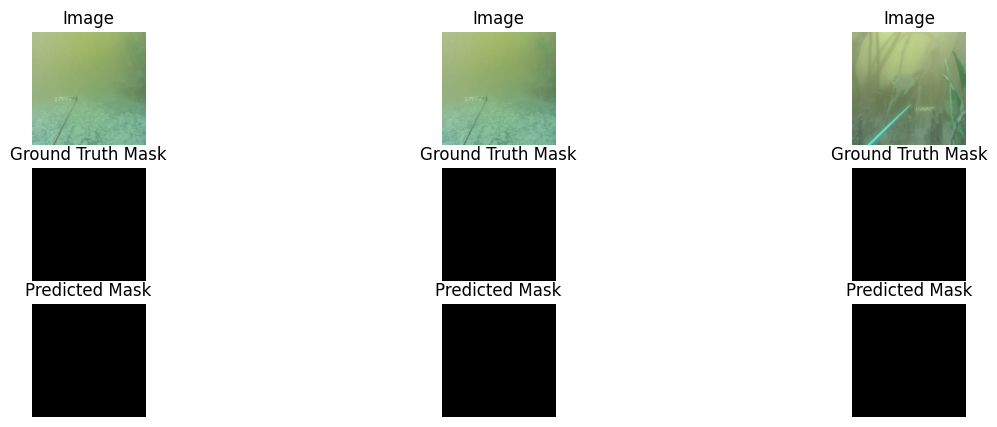

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


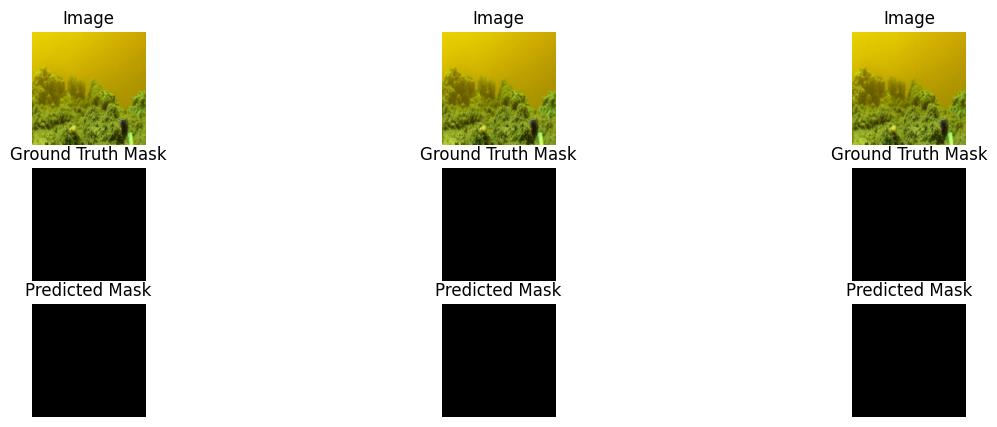

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


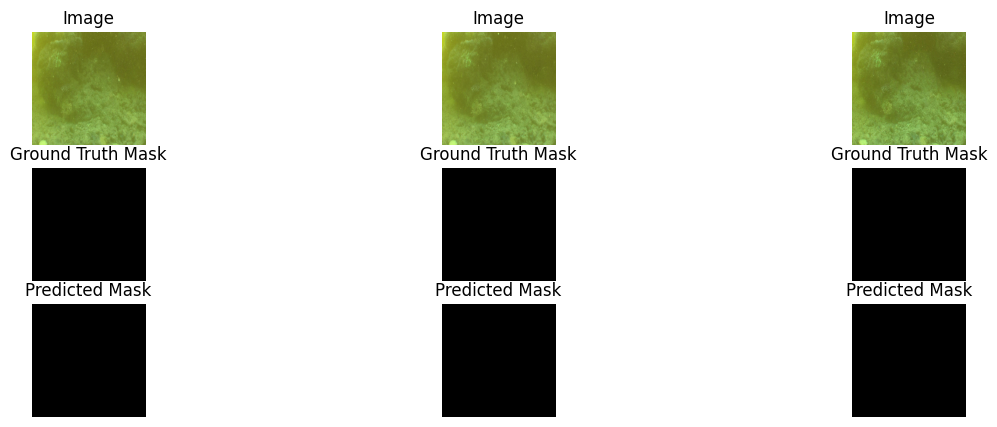

In [ ]:
import matplotlib.pyplot as plt

def display_sample_predictions(model, images, masks, sequence_length=3, num_samples=3):
    for i in range(num_samples):
        start_idx = np.random.randint(0, len(images) - sequence_length)

        # Extract a sequence of frames and masks
        image_sequence = images[start_idx:start_idx + sequence_length]
        mask_sequence = masks[start_idx:start_idx + sequence_length]

        # Predict masks for the sequence
        predicted_masks = model.predict(np.expand_dims(image_sequence, axis=0))[0]

        # Plot the results
        plt.figure(figsize=(15, 5))
        for t in range(sequence_length):
            plt.subplot(3, sequence_length, t + 1)
            plt.imshow(image_sequence[t])
            plt.title("Image")
            plt.axis('off')

            plt.subplot(3, sequence_length, t + 1 + sequence_length)
            plt.imshow(mask_sequence[t].squeeze(), cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(3, sequence_length, t + 1 + 2 * sequence_length)
            plt.imshow(predicted_masks[t].squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

        plt.show()

# Display sample predictions
display_sample_predictions(model, images, masks, sequence_length=sequence_length, num_samples=3)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt


In [ ]:
def process_video(video_path, model, sequence_length=3, output_path="output_video.mp4"):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))


    frames = []

    while True:
        ret, frame = video.read()
        if not ret:
            break


        frame_resized = cv2.resize(frame, (224, 224))
        frame_resized = frame_resized / 255.0


        frames.append(frame_resized)

        # If we have enough frames for a sequence
        if len(frames) == sequence_length:

            input_sequence = np.expand_dims(np.array(frames), axis=0)

            # Generate mask predictions
            predicted_masks = model.predict(input_sequence)[0]

            # Overlay mask on each frame in the sequence
            for i in range(sequence_length):
                mask = predicted_masks[i].squeeze()
                mask_resized = cv2.resize(mask, (width, height))
                mask_resized = (mask_resized > 0.5).astype(np.uint8) * 255  # Threshold the mask

                # Convert mask to color
                mask_color = cv2.applyColorMap(mask_resized, cv2.COLORMAP_JET)

                # Overlay mask on the original frame
                overlayed_frame = cv2.addWeighted(frame, 0.7, mask_color, 0.3, 0)

                # Write the frame with overlayed mask
                out.write(overlayed_frame)

            # Remove the first frame from the sequence to slide over the video
            frames.pop(0)

    video.release()
    out.release()
    print(f"Processed video saved as {output_path}")


In [ ]:
# Path to your uploaded video file
input_video_path = "/content/Segmentation/Test_Video/video.mp4"
output_video_path = "segmented_output_video.mp4"

# Run the segmentation on the video
process_video(input_video_path, model, sequence_length=sequence_length, output_path=output_video_path)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step